In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import json
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
import sys
#import joblib

%matplotlib inline

In [2]:
# Plot function for feature distribution
def plot_chart(df, col_name, col_type=None):
    
    if col_type == None:
        if is_string_dtype(df[col_name]):
            col_type = 'string'
        elif is_numeric_dtype(df[col_name]):
            col_type = 'numeric'
        else:
            print('Pass col_type to function to specify if it is string or numeric')
        
    if col_type == 'string':
        ax = df[col_name].value_counts().plot(kind='bar')
        ax.set_ylabel('Count')
    elif col_type == 'numeric':
        # if there are less than 10 values in the numeric column we redefine it as a string so we plot a bar chart
        if df[col_name].nunique() <= 10:
            ax = df[col_name].value_counts().sort_index().plot(kind='bar')
        else:
            ax = df[col_name].plot.density()
            
        ax.get_xaxis().set_major_formatter(
            plt.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    else:
        print(' Re-run specifying the col_type')

    ax.set_xlabel(col_name)
    ax.set_title(col_name + ' Column Distribution')

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)



In [3]:
def plot_categorical_vars(cat_var_for_plotting, prepped_data_pre_transform):
    df_temp = prepped_data_pre_transform.groupby(['cluster_id', cat_var_for_plotting]).size().reset_index()
    df_temp.rename(columns={0:'VALUES'}, inplace=True)
    df_temp = df_temp.pivot(index='cluster_id', columns=cat_var_for_plotting, values='VALUES').reset_index()
    df_temp
    
    ax = df_temp.set_index('cluster_id').plot(kind='bar', stacked=True, figsize=(12,7), title=cat_var_for_plotting + ' by Cluster')
    
    return 

In [4]:
def plot_numeric_vars(var, prepped_data_pre_transform, num_clusters):
    
    
    if len(prepped_data_pre_transform[var].unique()) > 2:
    
        plt.figure(figsize=(12,7))
        for cluster in range(0, num_clusters + 1):
            # Subset to the airline
            subset = prepped_data_pre_transform[prepped_data_pre_transform['cluster_id'] == cluster]
            try:
                # Draw the density plot
                sns.distplot(subset[var], hist = False, kde = True,
                             kde_kws = {'linewidth': 3},
                             label = 'cluster ' + str(cluster))

                plt.title('Density Plot for ' + var)    
            except:
                pass
    return

## User Inputs and Data Prep

### User Inputs
The user can use the default inputs as listed above or can choose their own. 


### Data Prep
See scripts/customer_segmentation_prep.py for details of data preparation.

### Data Cleaning

In [5]:
df = pd.read_csv('df_emr_pg_merged_pred_new.csv')
df_prof = df.copy()

In [6]:
df.head()

,survey_id,HOS,BGUNCODL,DISMM,DISDD,DISYR,OCCUR,CSURVEY,A1,A2,...,Age_group,Age_group_bin,Gender_ID,Description_Group,Physician_cat,Section_Group,Staff_Lab_Group,Slot_Type_ID,Nationality_ID,Marital_Status_ID
0,0,15611,1237,9,8,2019,2.0,1.0,5.0,4.0,...,36-45,5,2,2.0,Treatment Lab,4,2,3,1,1
1,0,15611,1237,9,8,2019,2.0,1.0,5.0,4.0,...,36-45,5,2,2.0,Treatment Lab,4,2,3,1,1
2,3,15611,1237,11,19,2018,2.0,1.0,3.0,3.0,...,66-75,8,1,3.0,Physician,1,1,1,1,1
3,8,15611,1234,7,24,2018,1.0,2.0,5.0,5.0,...,0-12,1,1,1.0,Infusion Zone,2,2,5,1,2
4,8,15611,1234,7,24,2018,1.0,2.0,5.0,5.0,...,0-12,1,1,1.0,Infusion Zone,2,2,5,1,2


In [7]:
df.shape

(3430, 87)

In [8]:
df.describe()

,survey_id,HOS,BGUNCODL,DISMM,DISDD,DISYR,OCCUR,CSURVEY,A1,A2,...,MRN,BIRTH_DT_TM,Age_group_bin,Gender_ID,Description_Group,Section_Group,Staff_Lab_Group,Slot_Type_ID,Nationality_ID,Marital_Status_ID
count,3430.000000,3430.0,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,...,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000
mean,2518.422741,15611.0,1235.512245,5.990379,15.729738,2018.843440,1.117201,1.361516,3.817201,3.901458,...,4422.967055,1970.361516,5.635569,1.546064,1.899417,2.667055,1.840525,3.734402,1.010204,1.371429
std,1489.006676,0.0,1.500169,3.394912,8.806968,0.740238,0.499894,0.522383,1.563508,1.547978,...,2639.638685,15.079199,1.590514,0.497946,1.412594,1.156943,0.366172,1.543861,0.164370,0.784213
min,0.000000,15611.0,1234.000000,1.000000,1.000000,2018.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,1924.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1212.000000,15611.0,1234.000000,3.000000,8.000000,2018.000000,1.000000,1.000000,3.000000,3.250000,...,2041.000000,1960.000000,5.000000,1.000000,1.000000,2.000000,2.000000,3.000000,1.000000,1.000000
50%,2529.500000,15611.0,1237.000000,6.000000,16.000000,2019.000000,1.000000,1.000000,4.000000,5.000000,...,4503.500000,1969.000000,6.000000,2.000000,2.000000,2.000000,2.000000,5.000000,1.000000,1.000000
75%,3832.000000,15611.0,1237.000000,9.000000,23.000000,2019.000000,1.000000,2.000000,5.000000,5.000000,...,6561.750000,1979.750000,7.000000,2.000000,2.000000,4.000000,2.000000,5.000000,1.000000,1.000000
max,5077.000000,15611.0,1237.000000,12.000000,31.000000,2020.000000,2.000000,3.000000,5.000000,5.000000,...,9625.000000,2019.000000,9.000000,2.000000,10.000000,4.000000,2.000000,5.000000,8.000000,5.000000


In [9]:
df.dtypes

survey_id            int64
HOS                  int64
BGUNCODL             int64
DISMM                int64
DISDD                int64
                     ...  
Section_Group        int64
Staff_Lab_Group      int64
Slot_Type_ID         int64
Nationality_ID       int64
Marital_Status_ID    int64
Length: 87, dtype: object

In [10]:
df.isnull().sum()

survey_id            0
HOS                  0
BGUNCODL             0
DISMM                0
DISDD                0
                    ..
Section_Group        0
Staff_Lab_Group      0
Slot_Type_ID         0
Nationality_ID       0
Marital_Status_ID    0
Length: 87, dtype: int64

In [11]:
# Drop the rows where at least one element is missing.
# df.fillna(0)
#print(df.isnull().sum().sum())

In [12]:
nan_percent = df.isnull().sum()/len(df)
nan_count = df.isnull().sum()
missing=pd.concat([nan_percent, nan_count], axis=1)
missing.columns = ['% Missing', 'Number missing']
missing.sort_values('% Missing',ascending=False)

,% Missing,Number missing
DESCRIPTION,0.004082,14
RTCT_Ave,0.000000,0
MED_RESOURCE_SERVICES,0.000000,0
DAYS,0.000000,0
MONTHS,0.000000,0
...,...,...
CT4,0.000000,0
CT3,0.000000,0
CT2,0.000000,0
CT1,0.000000,0


In [13]:
# Preview prepped data
#df_prepped.head()
df_prepped = df #origional df stays intact
df_prepped.isnull().sum()

survey_id            0
HOS                  0
BGUNCODL             0
DISMM                0
DISDD                0
                    ..
Section_Group        0
Staff_Lab_Group      0
Slot_Type_ID         0
Nationality_ID       0
Marital_Status_ID    0
Length: 87, dtype: int64

In [14]:
df_prepped.columns

Index(['survey_id', 'HOS', 'BGUNCODL', 'DISMM', 'DISDD', 'DISYR', 'OCCUR',
       'CSURVEY', 'A1', 'A2', 'REG1', 'REG2', 'FAC1', 'FAC2', 'FAC3', 'FAC4',
       'MED39', 'MED37', 'MED27', 'RT1', 'RT2', 'RT3', 'RT4', 'RT5', 'CT1',
       'CT2', 'CT3', 'CT4', 'CT5', 'CT6', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6',
       'I47', 'I17', 'I13', 'O1', 'O2', 'O3', 'RACE', 'SEX', 'AGE', 'A_Ave',
       'REG_Ave', 'FAC_Ave', 'MED_Ave', 'RT_Ave', 'CT_Ave', 'I_Ave', 'O_SCORE',
       'O_SCORE_3', 'RTCT_SCORE', 'RTCT_Ave', 'SECTION_ID', 'Expat_flag',
       'ENCOUNTER_ID', 'ORGANIZATION_NAME', 'YEARS', 'MONTHS', 'DAYS',
       'MED_RESOURCE_SERVICES', 'DESCRIPTION', 'PHYSICIAN_ATTENDING',
       'PRSNL_GROUP_NAME', 'DEPARTMENT_NAME', 'SECTIONS', 'APPT_DT_TM',
       'APPT_TYPE', 'SLOT_TYPE_DESC', 'MRN', 'BIRTH_DT_TM', 'GENDER',
       'PATIENT_NATIONALITY', 'MARITAL_STATUS', 'Age_group', 'Age_group_bin',
       'Gender_ID', 'Description_Group', 'Physician_cat', 'Section_Group',
       'Staff_Lab_Group', 

In [15]:
# Drop columns not needed for segmentation
df_prepped.drop([
'survey_id', 'HOS', 'BGUNCODL', 'DISMM', 'DISDD', 'DISYR', 'OCCUR',
       'CSURVEY', 'A1', 'A2', 'REG1', 'REG2', 'FAC1', 'FAC2', 'FAC3', 'FAC4',
       'MED39', 'MED37', 'MED27', 'RT1', 'RT2', 'RT3', 'RT4', 'RT5', 'CT1',
       'CT2', 'CT3', 'CT4', 'CT5', 'CT6', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6',
       'I47', 'I17', 'I13', 'O1', 'O2', 'O3', 'RACE', 'SEX', 'AGE', 'A_Ave',
       'REG_Ave', 'FAC_Ave', 'MED_Ave', 'RT_Ave', 'CT_Ave', 'I_Ave', 
       'O_SCORE_3', 'RTCT_SCORE', 'RTCT_Ave','Expat_flag',
       'ENCOUNTER_ID', 'ORGANIZATION_NAME', 'YEARS', 'MONTHS', 'DAYS',
       'MED_RESOURCE_SERVICES', 'DESCRIPTION', 'PHYSICIAN_ATTENDING',
       'PRSNL_GROUP_NAME', 'DEPARTMENT_NAME', 'SECTIONS', 'APPT_DT_TM',
       'APPT_TYPE', 'SLOT_TYPE_DESC', 'MRN', 'BIRTH_DT_TM', 'GENDER',
       'PATIENT_NATIONALITY', 'MARITAL_STATUS', 'Age_group', 
       'Description_Group', 'Physician_cat', 'Section_Group',
       'Staff_Lab_Group', 'Slot_Type_ID',
       'Marital_Status_ID'], axis=1, inplace=True)

In [16]:
df_prepped.shape

(3430, 5)

### Dummy Variables

Next, since our data contains mixed data types, categorical and numeric, we need to convert those categorical features to numeric by creating binary dummy variables. Once we create the dummy variables from the categorical features we'll drop the original categorical features.

In [17]:
# Create lists of the numeric and categorical features
numeric_cols = list(df_prepped.select_dtypes(include=[np.number]).columns)
categorical_cols = list(df_prepped.select_dtypes(include=[object]).columns)




In [18]:
# Copy of the prepped dataframe before any transformations are carried out
prepped_data_pre_transform = df_prepped.copy()

In [19]:

# Create dummy variables for categorical features and drop original
for col in categorical_cols:
    df_prepped = pd.concat([df_prepped, pd.get_dummies(df_prepped[col], prefix=col, drop_first=True)], axis=1)
    df_prepped.drop(col, axis=1, inplace=True)

### Standardize Data

The last step for our data preparation is to standardize the numeric variables. Standardizing numeric values prior to clustering is common practice especially when dealing with features of varying scales (number of children vs summary of assets amount). This helps to improve the cluster quality as well as cluster algorithm accuracy and performance.

In [20]:
# Calculate mean and standard deviation for standardization
numeric_cols_to_exclude_from_clustering = []
dict_col_means = {}
dict_col_stds = {}
for col in numeric_cols:
    col_mean = df_prepped[col].mean()
    col_std = df_prepped[col].std()
    dict_col_means[col] = col_mean
    dict_col_stds[col] = col_std
    numeric_cols_to_exclude_from_clustering.append(col)
    
    df_prepped[col + '_std'] = (df_prepped[col] - col_mean)/col_std

# store the means and standard deviations in one dictionary
dict_standardise = {'mean':dict_col_means, 'std':dict_col_stds}

# drop the numeric columns from clustering data set
df_prepped.drop(numeric_cols_to_exclude_from_clustering, axis=1, inplace=True)

In [21]:
# Preview prepped data with atandardized numeric values
#df_prepped.drop(['DOB'],axis=1, inplace=True)
df_prepped.head

<bound method NDFrame.head of       O_SCORE_std  SECTION_ID_std  Age_group_bin_std  Gender_ID_std  \
0       -0.414485       -0.991725          -0.399599       0.911616   
1       -0.414485       -0.991725          -0.399599       0.911616   
2        2.411926       -0.991725           1.486583      -1.096633   
3       -0.414485        1.008050          -2.914510      -1.096633   
4       -0.414485        1.008050          -2.914510      -1.096633   
...           ...             ...                ...            ...   
3425    -0.414485       -0.991725           0.857856       0.911616   
3426    -0.414485       -0.991725           0.229128       0.911616   
3427    -0.414485       -0.991725           0.229128       0.911616   
3428    -0.414485        1.008050          -1.028327      -1.096633   
3429    -0.414485        1.008050          -1.028327      -1.096633   

      Nationality_ID_std  
0               -0.06208  
1               -0.06208  
2               -0.06208  
3        

## Principal Component Analysis (PCA)

Now that our data is clean with some transformations we're going to do one last transformation. We'll use principal components analysis (PCA) to reduce the dimensionality of our data and reduce clustering computation. Also, performing PCA prior to clustering can often help with performance if there are underlying linear relationships with the data. This isn't always the case and is dependent on your data, but it did hold true with our customer dataset.

In [22]:
# PCA
pca = PCA(n_components=5)
df_pca = pca.fit_transform(df_prepped)

# Preview transformed data
pd.DataFrame(df_pca).head()

,0,1,2,3,4
0,-0.131194,0.851642,-0.354422,-0.675246,0.908745
1,-0.131194,0.851642,-0.354422,-0.675246,0.908745
2,-2.130939,-1.412268,1.890039,0.272492,0.188137
3,2.355005,-1.133544,-1.186174,1.196908,1.103728
4,2.355005,-1.133544,-1.186174,1.196908,1.103728


In [23]:
# Percent variance explained array
print(np.cumsum(pca.explained_variance_ratio_))

[0.22931297 0.44077112 0.63875619 0.8290158  1.        ]


## K-means Clustering

We can now begin clustering. For clustering we'll use the k-means clustering algorithm. K-means clustering simply partitions the data into k clusters where each observation or client belongs to the cluster with the nearest mean. When using k-means you have to specify the number of clusters beforehand, but often times that number is unknown. We'll loop through the k-means algorithm using a range of number of clusters and determine cluster number by using the metric called **silhouette coefficient**. The silhouette coefficient indicates how similar the observations within its own cluster are compared to other observations in different clusters. Range for silhouette coefficient are from -1 to 1 where 1 represents objects within its own cluster are well paired.

In [24]:
# Specify max number of clusters for iteration
max_number_of_clusters = 10

# Loop through K-means and view silhouette coefficient to determine number of clusters
for i in range(2, max_number_of_clusters+1):
    kmeans_mdl = KMeans(n_clusters=i, random_state=1234)
    kmeans_mdl.fit(df_prepped)
    labels = kmeans_mdl.labels_
    df['kmean'] = kmeans_mdl.labels_
    silhouette_coef = metrics.silhouette_score(df_prepped, labels, metric='euclidean')
    print('Silhouette coefficient for ' + str(i) + ' clusters:' + str(silhouette_coef))
#     print (df['kmean'].value_counts())

Silhouette coefficient for 2 clusters:0.33720204289735833
Silhouette coefficient for 3 clusters:0.40853769020960956
Silhouette coefficient for 4 clusters:0.41099260505300783
Silhouette coefficient for 5 clusters:0.5186003532244471
Silhouette coefficient for 6 clusters:0.6201657311076035
Silhouette coefficient for 7 clusters:0.5632223262940707
Silhouette coefficient for 8 clusters:0.6578889387415989
Silhouette coefficient for 9 clusters:0.6341523951488428
Silhouette coefficient for 10 clusters:0.6860665016210037


In [25]:
# K-means with 3 clusters based on silhouette coefficient
num_clusters = 3
kmeans_mdl = KMeans(n_clusters=num_clusters, random_state=1234)
pc_clusters = kmeans_mdl.fit_predict(df_prepped)

In [26]:
# Create dataframe with PCA and cluster assignments
# incrmeent the cluster number by 1 so that cluster numbers start at 1 instead of 0
df_pca_clusters = pd.DataFrame(df_pca, columns=['pc_1','pc_2','pc_3','pc_4','pc_5'])
df_pca_clusters['cluster_id'] = pc_clusters + 1
df_pca_clusters.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,cluster_id
0,-0.131194,0.851642,-0.354422,-0.675246,0.908745,3
1,-0.131194,0.851642,-0.354422,-0.675246,0.908745,3
2,-2.130939,-1.412268,1.890039,0.272492,0.188137,1
3,2.355005,-1.133544,-1.186174,1.196908,1.103728,1
4,2.355005,-1.133544,-1.186174,1.196908,1.103728,1


In [27]:
df_pca_clusters['cluster_id'].value_counts()

1    1534
2    1053
3     843
Name: cluster_id, dtype: int64

## Visualize Clusters

To see the visual representation of our newly assigned clusters we plot, on a 2-dimensional plot, the 1st principal component with the 2nd principal component as the x and y-axis. Then we set the `cluster_id` as the color so we can better visualize the cluster assignments or segments. You can see from below that we have some nice exclusiveness with our clusters even on the 2-dimensional space.

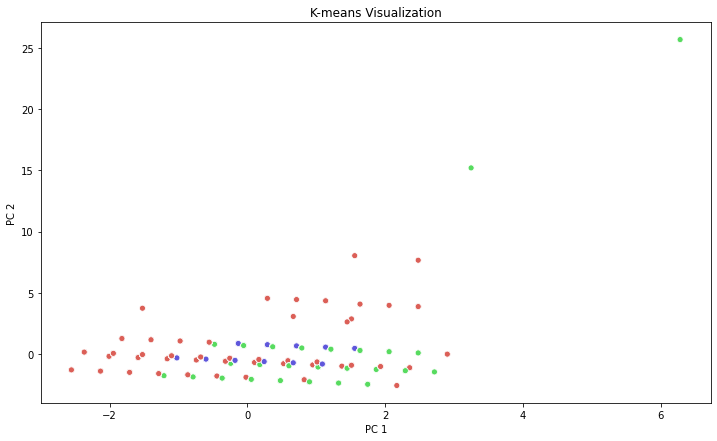

In [28]:
import seaborn as sns

# Plot k-means results with cluster assignments
plt.figure(figsize=(12,7))

ax = sns.scatterplot(
    x="pc_1",
    y="pc_2",
    data=df_pca_clusters,
    hue="cluster_id",
    legend=False,
    palette=sns.color_palette("hls", num_clusters)
)

ax.set(xlabel="PC 1", ylabel="PC 2", title="K-means Visualization");

## Profiling - Distribution Plot per variable 

The below code loops through each categorical variable and plots the distribution of each variable by cluster, followed by doing the same for numerical variables. 

In [29]:
# Drop columns not needed for segmentation
# df_prof.drop([
# 'survey_id', 'HOS', 'BGUNCODL', 'DISMM', 'DISDD', 'DISYR', 'OCCUR',
#        'CSURVEY', 'A1', 'A2', 'REG1', 'REG2', 'FAC1', 'FAC2', 'FAC3', 'FAC4',
#        'MED39', 'MED37', 'MED27', 'RT1', 'RT2', 'RT3', 'RT4', 'RT5', 'CT1',
#        'CT2', 'CT3', 'CT4', 'CT5', 'CT6', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6',
#        'I47', 'I17', 'I13', 'O1', 'O2', 'O3', 'RACE', 'SEX', 'AGE', 'A_Ave',
#        'REG_Ave', 'FAC_Ave', 'MED_Ave', 'RT_Ave', 'CT_Ave', 'I_Ave', 
#        'O_SCORE_3', 'RTCT_SCORE', 'RTCT_Ave','Expat_flag',
#        'ENCOUNTER_ID', 'ORGANIZATION_NAME', 'YEARS', 'MONTHS', 'DAYS',
#        'MED_RESOURCE_SERVICES', 'DESCRIPTION', 'PHYSICIAN_ATTENDING',
#        'PRSNL_GROUP_NAME', 'DEPARTMENT_NAME', 'SECTIONS', 'APPT_DT_TM',
#        'APPT_TYPE', 'SLOT_TYPE_DESC', 'MRN', 'BIRTH_DT_TM', 'GENDER',
#        'PATIENT_NATIONALITY', 'MARITAL_STATUS', 'Age_group', 
#        'Description_Group', 'Physician_cat', 'Section_Group',
#        'Staff_Lab_Group', 'Slot_Type_ID',
#        'Marital_Status_ID'], axis=1, inplace=True)
df_prof.drop([
'survey_id',
'HOS',
'BGUNCODL',
'DISMM',
'DISDD',
'DISYR',
'CSURVEY',
'A1',
'A2',
'REG1',
'REG2',
'FAC1',
'FAC2',
'FAC3',
'FAC4',
'MED39',
'MED37',
'MED27',
'RT2',
'RT3',
'RT4',
'RT5',
'CT2',
'CT3',
'CT4',
'CT5',
'CT6',
'I1',
'I2',
'I3',
'I4',
'I5',
'I6',
'I47',
'I17',
'I13',
'O1',
'O2',
'O3',
'RACE',
'SEX',
'AGE',
'RTCT_SCORE',
'RTCT_Ave',
'Expat_flag',
'ENCOUNTER_ID',
'ORGANIZATION_NAME',
'YEARS',
'MONTHS',
'DAYS',
'MED_RESOURCE_SERVICES',
'DESCRIPTION',
'PHYSICIAN_ATTENDING',
'PRSNL_GROUP_NAME',
'DEPARTMENT_NAME',
'SECTIONS',
'APPT_DT_TM',
'APPT_TYPE',
'MRN',
'BIRTH_DT_TM',
'MARITAL_STATUS',
'Age_group',
'Slot_Type_ID'], axis=1, inplace=True)

In [30]:
df_prof['cluster_id'] = df_pca_clusters['cluster_id']
# print (df_prof.columns)

# Create lists of the numeric and categorical features
numeric_cols = list(df_prof.select_dtypes(include=[np.number]).columns)
categorical_cols = list(df_prof.select_dtypes(include=[object]).columns)

print ("Numeric Columns: \n",numeric_cols)

print ("\n Categorical Columns: \n",categorical_cols)

Numeric Columns: 
 ['OCCUR', 'RT1', 'CT1', 'A_Ave', 'REG_Ave', 'FAC_Ave', 'MED_Ave', 'RT_Ave', 'CT_Ave', 'I_Ave', 'O_SCORE', 'O_SCORE_3', 'SECTION_ID', 'Age_group_bin', 'Gender_ID', 'Description_Group', 'Section_Group', 'Staff_Lab_Group', 'Nationality_ID', 'Marital_Status_ID', 'cluster_id']

 Categorical Columns: 
 ['SLOT_TYPE_DESC', 'GENDER', 'PATIENT_NATIONALITY', 'Physician_cat']


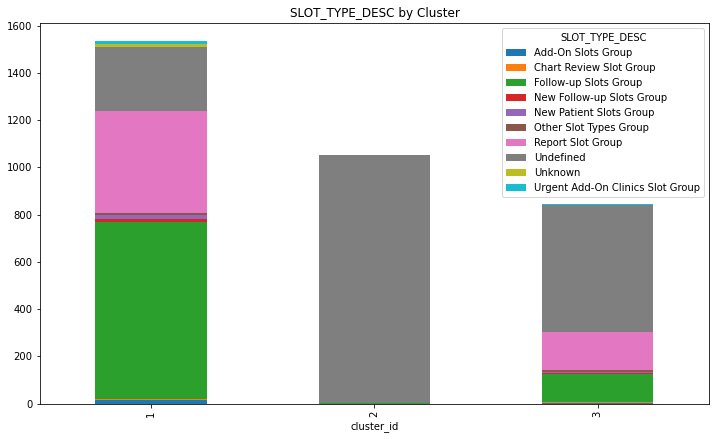

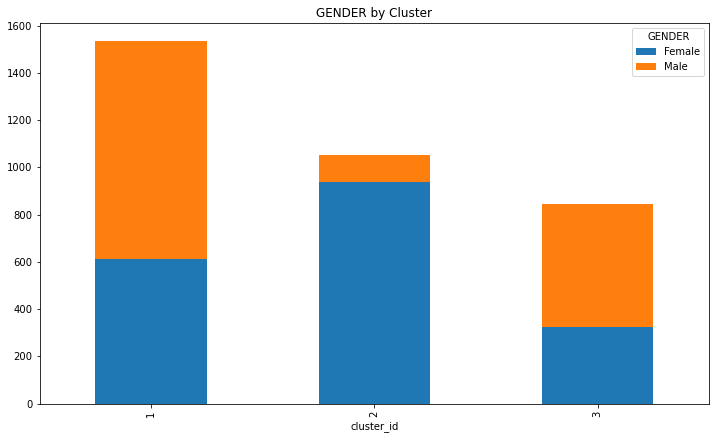

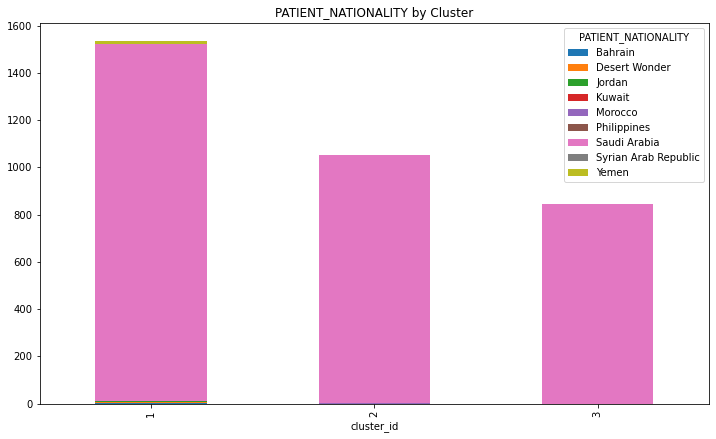

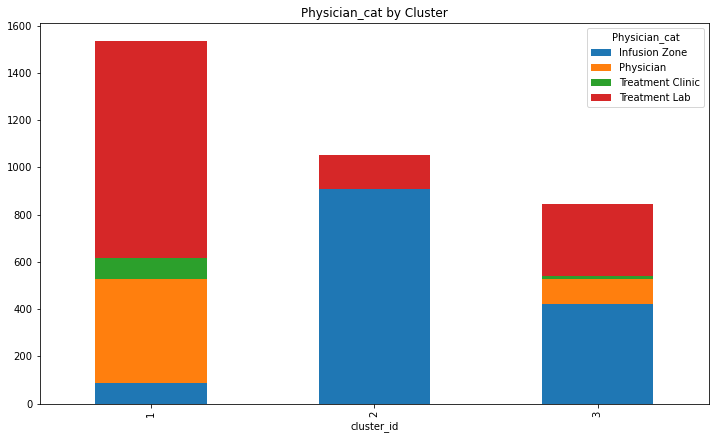

In [31]:
for var in categorical_cols:
    plot_categorical_vars(var, df_prof)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib

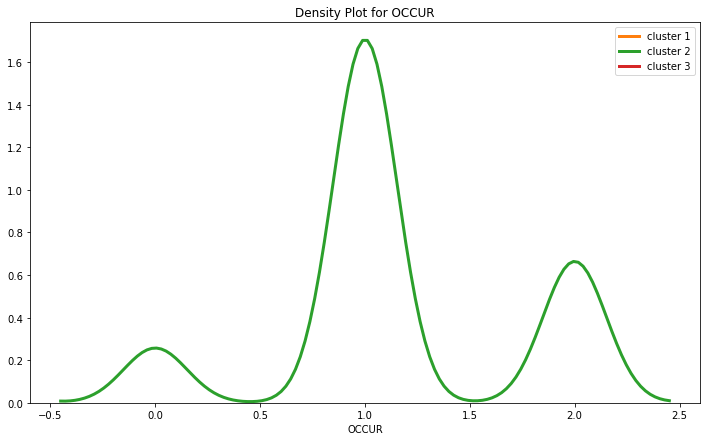

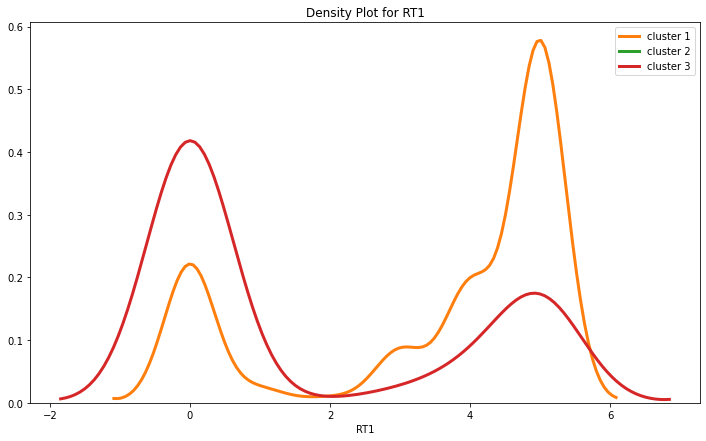

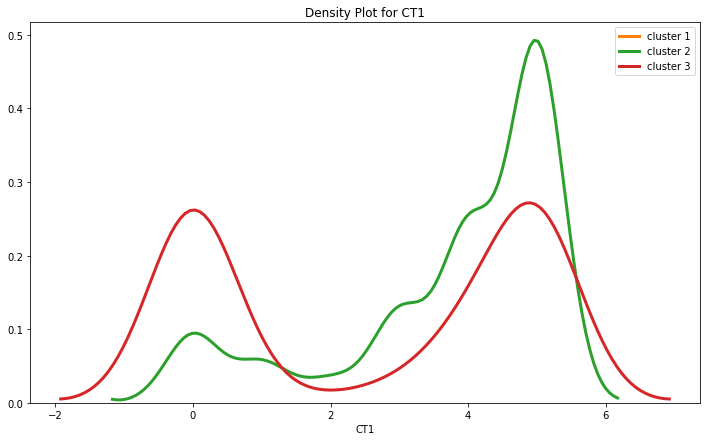

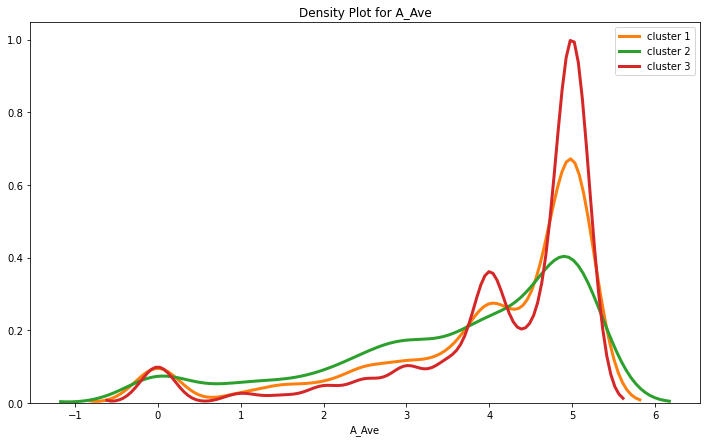

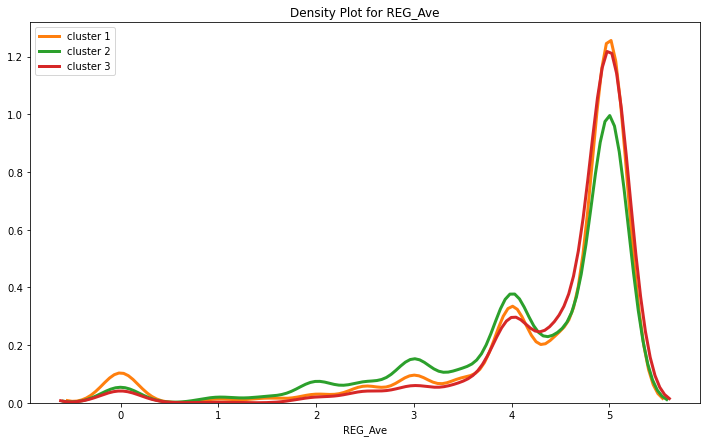

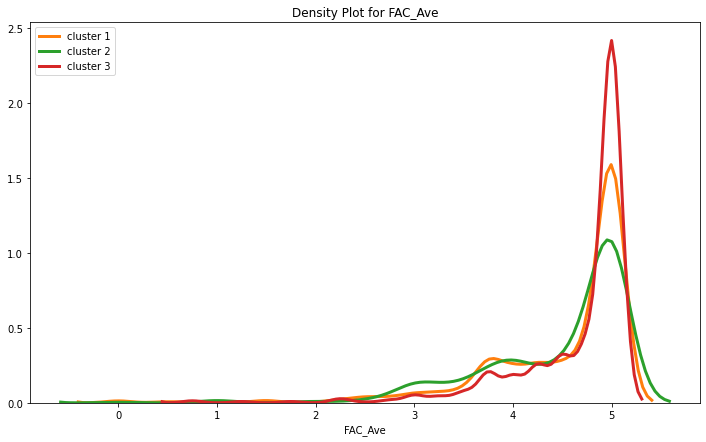

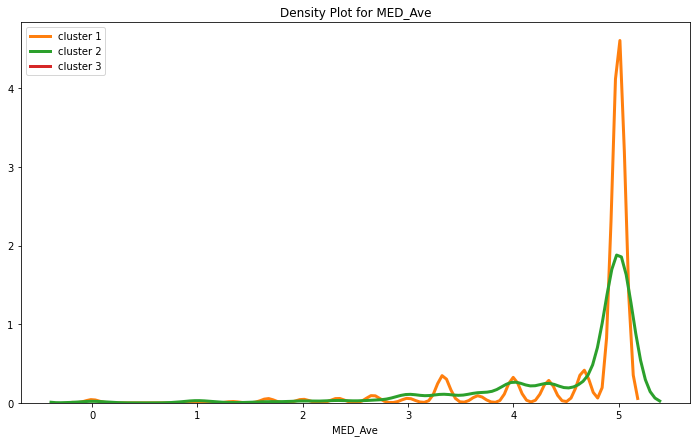

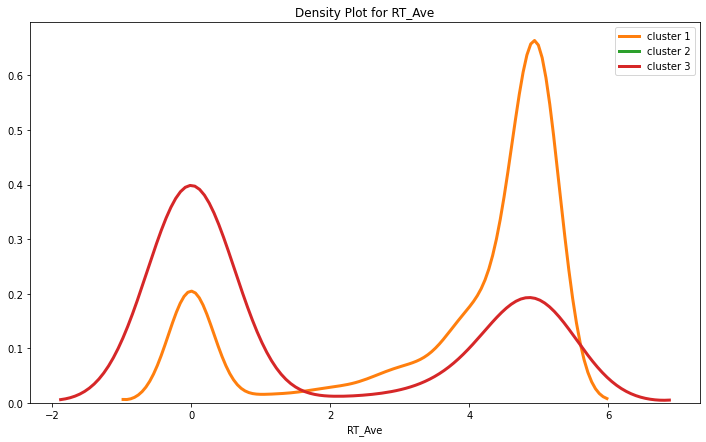

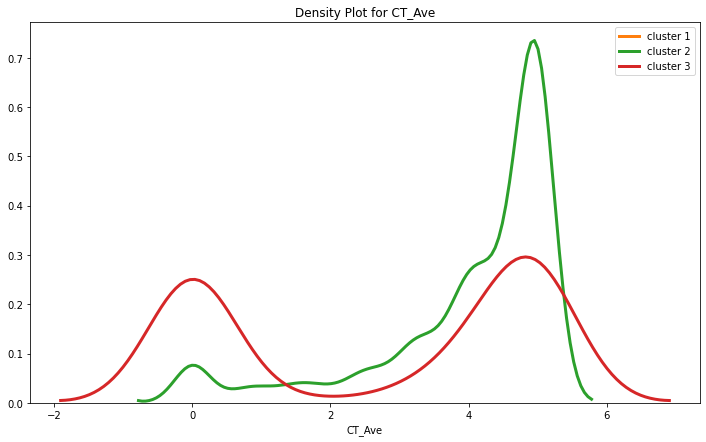

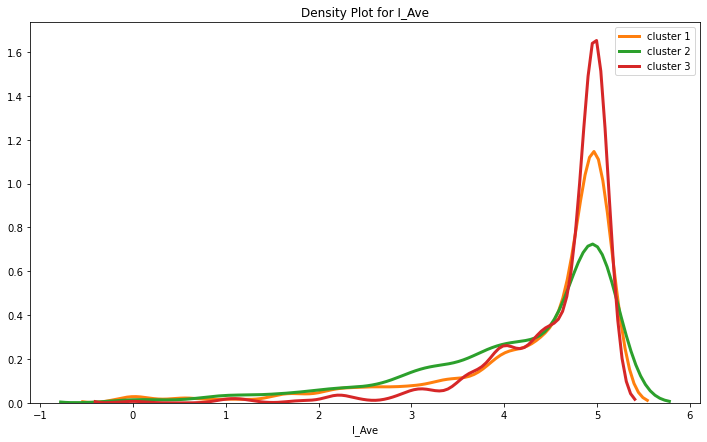

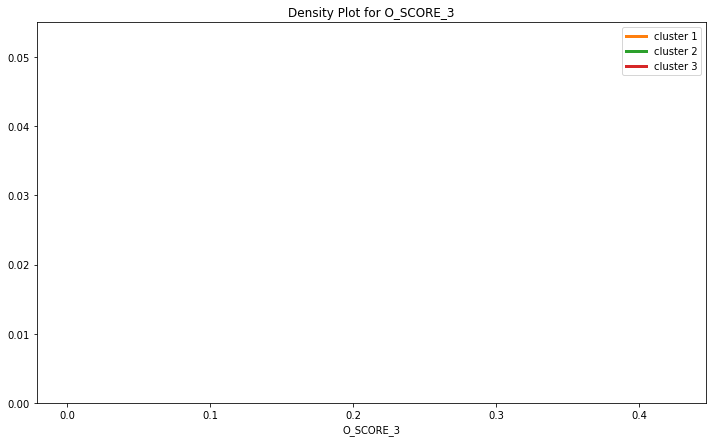

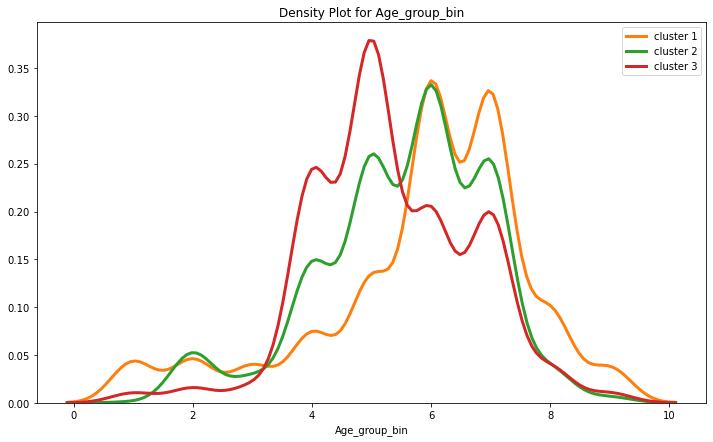

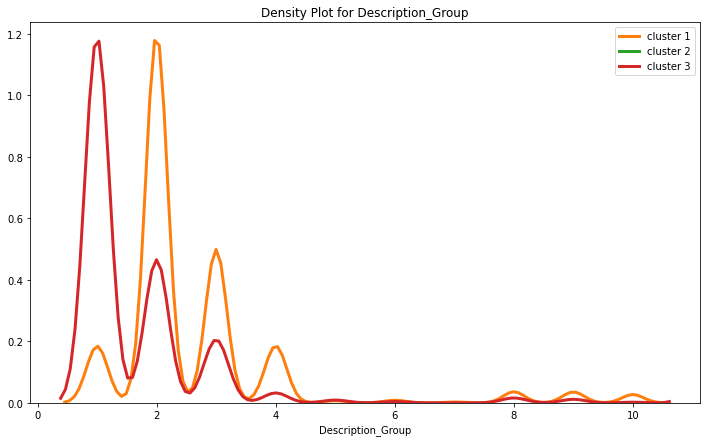

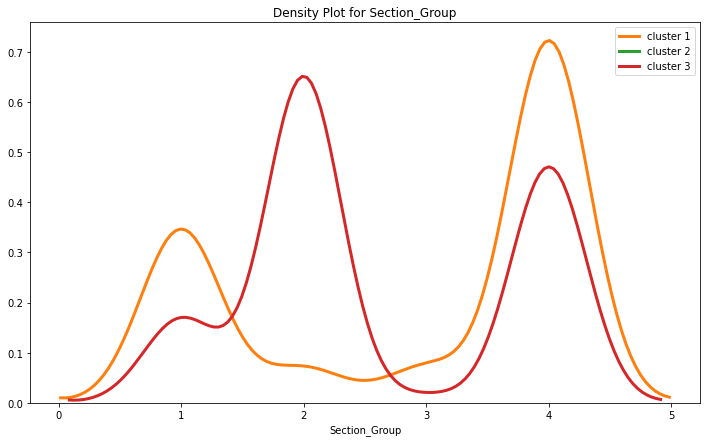

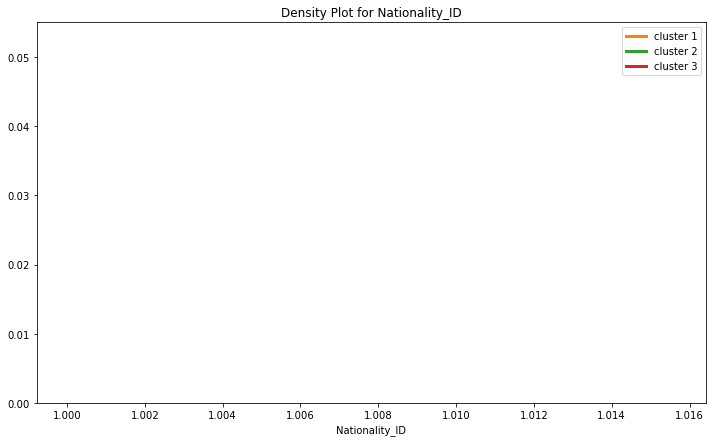

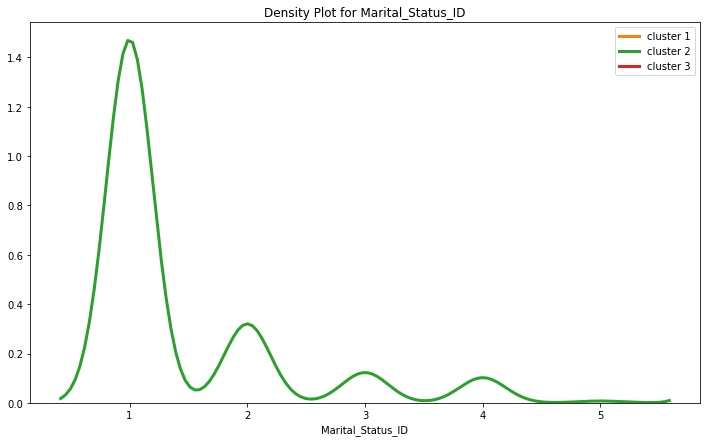

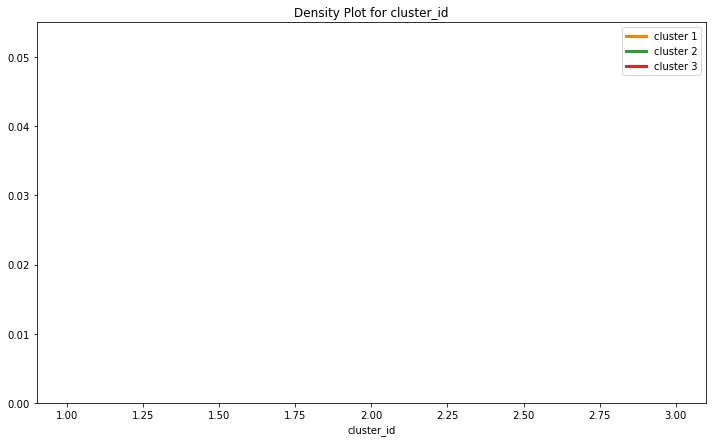

In [32]:
for col in numeric_cols:
    plot_numeric_vars(col, df_prof, num_clusters)